# Lab 3: final challenges

__Вам предлагается решить задачу классификации сигналов (вы уже встречались с ней во второй лабораторной работе) или задачу классификации изображений. Или обе ;)__

__Выполнение этих заданий не является обязательным, но позитивно повлияет на вашу итоговую оценку. Успехов!__


In [0]:
import time

import copy
import natsort

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os

import csv

from sklearn.metrics import accuracy_score

from PIL import Image

import torch
import torch.nn as nn
from torch import utils

import torchvision
from torchvision import transforms
from torchvision import models

import torchsummary

from IPython import display

import matplotlib
matplotlib.rcParams.update({'font.size':14})

%matplotlib inline

In [2]:
def LOG(text):
    print(text)
    print('-'*70)

try:
    import google.colab
    USE_COLAB = True
except:
    USE_COLAB = False

if USE_COLAB:
    LOG("""Don't forget to avoid disconnections:
function ClickConnect(){
    console.log("Clicking"); 
    document.querySelector("colab-connect-button").click() 
}
setInterval(ClickConnect,60000)
    """)

WORK_DIR = './'
if USE_COLAB:
    from google.colab import files, drive
    WORK_DIR = '/content/drive/'
    drive.mount(WORK_DIR)
    WORK_DIR += 'My Drive/projects/lab-3-har/'
LOG(f"Working directory is {WORK_DIR}")

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
LOG(f'Using device is {device}')

Don't forget to avoid disconnections:
function ClickConnect(){
    console.log("Clicking"); 
    document.querySelector("colab-connect-button").click() 
}
setInterval(ClickConnect,60000)
    
----------------------------------------------------------------------
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
Working directory is /content/drive/My Drive/projects/lab-3-har/
----------------------------------------------------------------------
Using device is cuda:0
-----------------------------------------

# Part 4. HAR classification with raw data (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.


Данное задание составлено на основе данного [поста](https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/). С помощью вручную сгенерированных фичей и классических подходов задача распознования движений была решена с точностью 96%. 

Также будет полезным изучить [вот этот](https://github.com/healthDataScience/deep-learning-HAR), а так же [вот этот репозиторий](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition), где к данной задаче рассматривается несколько подходов.

Вернемся к задаче классификации движений на основе [данных](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) из репозитория UCI ([прямая ссылка на скачивание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip)). 

В этот раз будем работать с исходными, а не предобработанными данными. Данные представляют собой сигналы с гироскопа и акселерометра, закрепленного на теле человека. Каждому семплу соотвествует 9 связанных временных рядов.

## Подготовка данных

### Загрузка датасета

In [17]:
# Загрузка датасета
dataset_name = 'UCI HAR Dataset'
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"
!unzip "$dataset_name" > /dev/null
!ls "$dataset_name"

--2020-05-26 14:10:06--  https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60999314 (58M) [application/x-httpd-php]
Saving to: ‘UCI HAR Dataset.zip.5’

UCI HAR Dataset.zip 100%[===================>]  58.17M  69.3MB/s    in 0.8s    

2020-05-26 14:10:07 (69.3 MB/s) - ‘UCI HAR Dataset.zip.5’ saved [60999314/60999314]

replace __MACOSX/UCI HAR Dataset/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
activity_labels.txt  features_info.txt	features.txt  README.txt  test	train


### Визуализация

В начале приведена визуализация данных на основе PCA над вручную сгенерированными признаками. Для отрисовки графиков (цвет и легенда) нам также понадобятся метки классов.

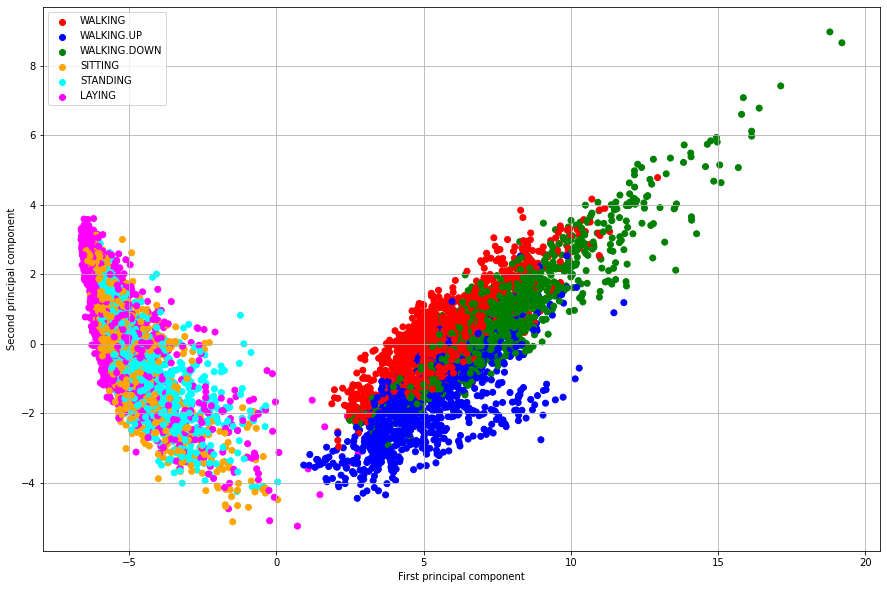

In [19]:
X_train_with_engineered_features = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "X_train.txt"))
y_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0], 
                x[1], 
                c=colors_list[idx], 
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()
plt.show()

### Предобработка данных
Предобработка сделана за нас автором [данного репозитория](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition). Будьте осторожны с путями.

In [20]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


Dataset is now located at: ./UCI HAR Dataset/


In [21]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


### Завернём всё в dataloader

In [0]:
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train).permute(0, 2, 1), torch.tensor(y_train).long())
test_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test).permute(0, 2, 1), torch.tensor(y_test).long())

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=512,
    num_workers=0,
    shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=512,
    num_workers=0,
    shuffle=True
)

## Определение функционала

### Определим основную сеть со Свёрточными слоями


In [0]:
class ConvNet(nn.Module):
    def __init__(self, input_shape, n_classes):
        super(ConvNet, self).__init__()

        self.body = nn.Sequential(
            nn.Conv1d(9, 18, kernel_size=2, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            
            nn.Conv1d(18, 36, kernel_size=2, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),

            nn.Conv1d(36, 72, kernel_size=2, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),

            nn.Conv1d(72, 144, kernel_size=2, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),

            nn.Flatten()
        )
        fake_body = copy.deepcopy(self.body)
        output_shape = np.array(fake_body(torch.ones([1, *input_shape])).shape)

        self.fc = nn.Linear(output_shape[1:].prod(), n_classes)
    
    def forward(self, inputs):
        output = self.body(inputs)
        return self.fc(output)

### Определим функции получения модификаций

#### Заменим последний полносвязный слой на два с Dropout'ом

In [0]:
def get_convnet(input_shape, n_classes):
    return ConvNet(input_shape, n_classes)

In [0]:
def get_convnet_2fc(input_shape, n_classes):
    net = get_convnet(input_shape, n_classes)
    
    num_ftrs = net.fc.in_features
    net.fc = nn.Sequential(
        nn.Linear(num_ftrs, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5, inplace=False),
        nn.Linear(256, n_classes)
    )
    return net

### Определим класс для обучения

In [0]:
class LearningModel:
    def __init__(self, net, net_name):
        self.net = net
        self.net_name = net_name
        self.optimizer = torch.optim.Adam(net.parameters(), lr=5e-5)
        self.criterion = nn.CrossEntropyLoss()
        self.epoch = 0
        self.metrics = {'accuracy' : {}, 'loss' : {}}
    
    def predict(self, input):
        return self.net.forward(input).argmax(axis=-1)
    
    def get_acc(self, data_batch, label_batch):
        predictions = self.predict(data_batch)
        return (predictions == label_batch).float().mean()

    def get_loss(self, data_batch, label_batch):
        predictions = self.net.forward(data_batch)
        loss = self.criterion(predictions, label_batch)
        return loss

    def evaluate(self, data_loaders):
        with torch.no_grad():
            for name, data_loader in data_loaders.items():
                metrics_sum = {'accuracy':0., 'loss':0.}
                metrics_func = {'accuracy':self.get_acc, 'loss':self.get_loss}
                total_num = 0.
                for data_batch, label_batch in data_loader:
                    batch_size = data_batch.shape[0]
                    data_batch = data_batch.to(device)
                    label_batch = label_batch.flatten().to(device)
                    
                    for k in metrics_sum.keys():
                        metrics_sum[k] += metrics_func[k](data_batch, label_batch) * batch_size
                    
                    total_num += batch_size
                
                for k, v in metrics_sum.items():
                    self.metrics[k].setdefault(name, [])
                    self.metrics[k][name].append(v / total_num)


    def fit(self,
            data_loaders,
            n_epoch=20,
           ):
        self.n_epoch = n_epoch

        while self.epoch <= n_epoch:
            display.clear_output(wait=True)
            self.evaluate(data_loaders)
            self.visualize()
            if self.epoch == n_epoch:
                break

            for data_batch, label_batch in data_loaders['train']:
                data_batch = data_batch.to(device)
                label_batch = label_batch.flatten().to(device)

                self.optimizer.zero_grad()
                
                loss = self.get_loss(data_batch, label_batch)
            
                # Backward
                loss.backward()
                
                # Update weights
                self.optimizer.step()
            
            self.epoch += 1

        return self
    
    def visualize_metric(self, ax, metric_name):
        ax.set_title(metric_name)
        ax.set_xlabel('Epoch num')
        ax.set_ylabel(metric_name)

        for k, v in self.metrics[metric_name].items():
            ax.plot(v, label=f'On {k} {metric_name}={v[-1]}')
        
        ax.legend(loc='best')

    def visualize(self, independ_plot=False):
        print('Epoch {}/{}'.format(self.epoch, self.n_epoch))

        fig = plt.figure(figsize=(29.7/2, 21.))
        fig.subplots_adjust(top=0.95)
        plt.suptitle(self.net_name, fontsize=20)
        
        loss_ax = fig.add_subplot(2, 1, 1)
        acc_ax = fig.add_subplot(2, 1, 2)

        self.visualize_metric(loss_ax, 'loss')
        self.visualize_metric(acc_ax, 'accuracy')
        
        plt.legend(loc='best')
        plt.show()

### Протестируем

Epoch 1/1


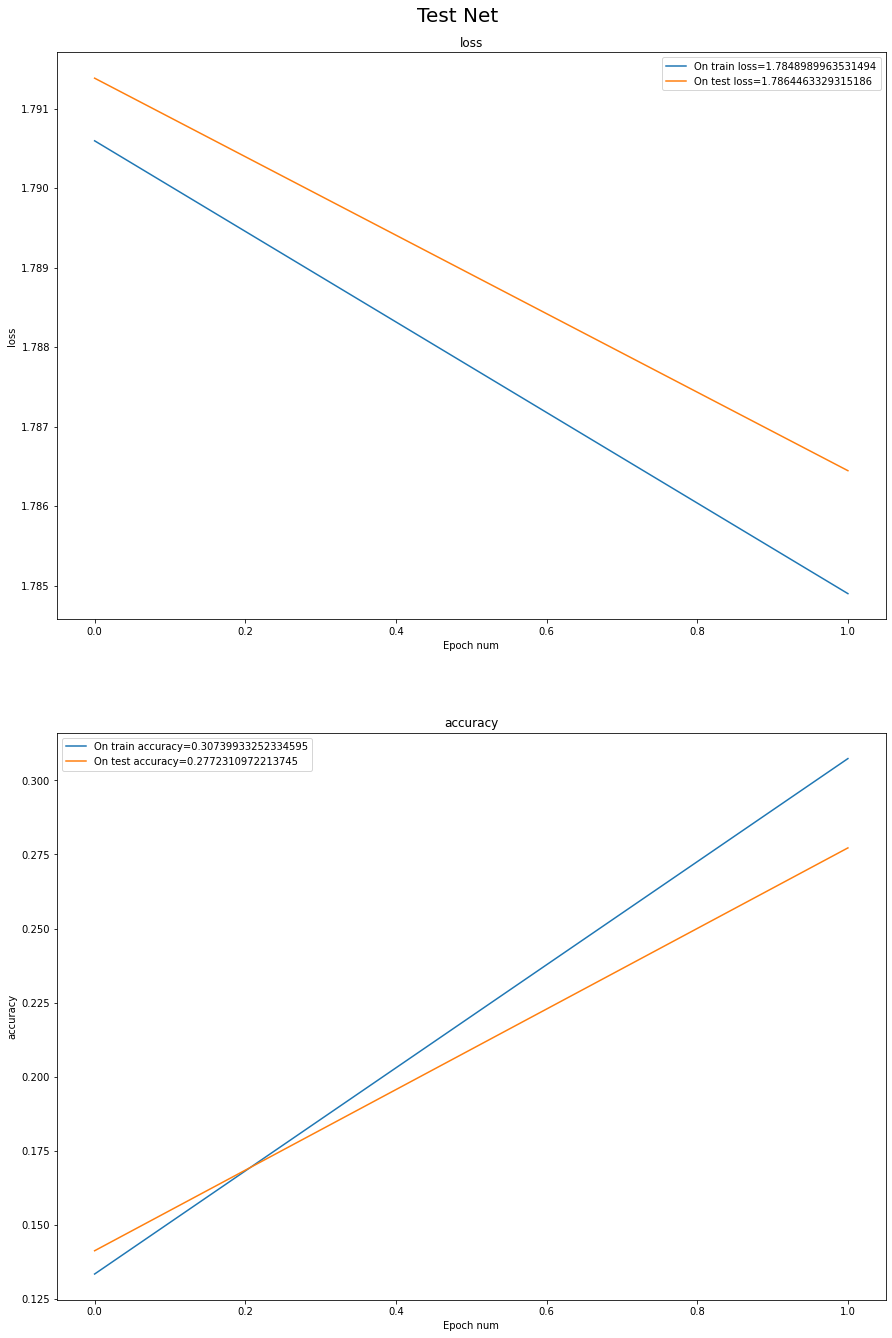

TESTs PASSED


In [160]:
test_batch = torch.zeros((128, 9, 128)).to(device)
test_net = ConvNet(test_batch.shape[1:], 6).to(device)
test_output = test_net(test_batch)
test_net_lm = LearningModel(test_net, 'Test Net')
test_dataloaders = {
    'train' : train_dataloader,
    'test' : test_dataloader
}
assert test_output.shape == (128, 6), 'wrong forward'
assert test_net_lm.fit(test_dataloaders, n_epoch = 1)

print('TESTs PASSED')

## Построение сети и эксперименты. (100% +)

__Ваша задача - построить сеть, которая решит задачу классификации с точностью (`accuracy`) не менее 86%.__
Разбалловка следующая:
* $=$86% - 2 points
* $>=$89% - 2.5 points
* $>=$91% - 3 points


__Warning!__ В сети существует несколько решений данной задачи с использованием различных фреймворков. При проверке это будет учитываться, так что свое решение нужно будет объяснить. Пожалуйста, не копируйте бездумно код, такие задания будут оценены 0 баллов. Если задача не решается - можете обратиться к заданию по классификации изображений.

### Проведём эксперименты со свёрточной нейронной сетью

#### Обучим "чистую" версию

Epoch 520/520


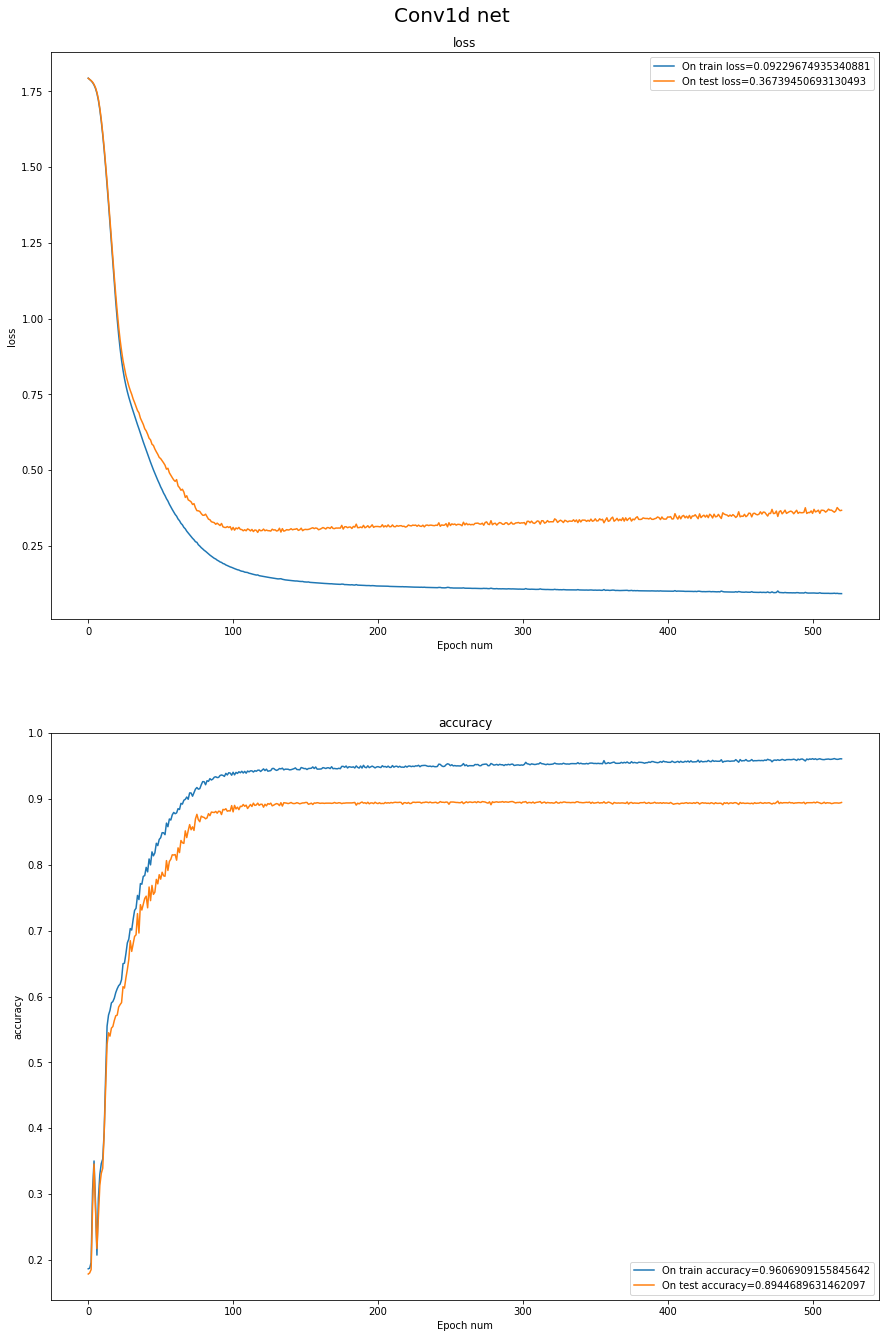

CPU times: user 7min 40s, sys: 1min 12s, total: 8min 53s
Wall time: 8min 55s


In [167]:
%%time 
convnet = get_convnet([9, 128], 6).to(device)
convnet_lm = LearningModel(convnet, 'Conv1d net')
convnet_lm.fit(
    {
        'train' : train_dataloader,
        'test' : test_dataloader
    },
    n_epoch=520
)

#### А теперь версию с двумя полносвязными слоями

Epoch 210/400


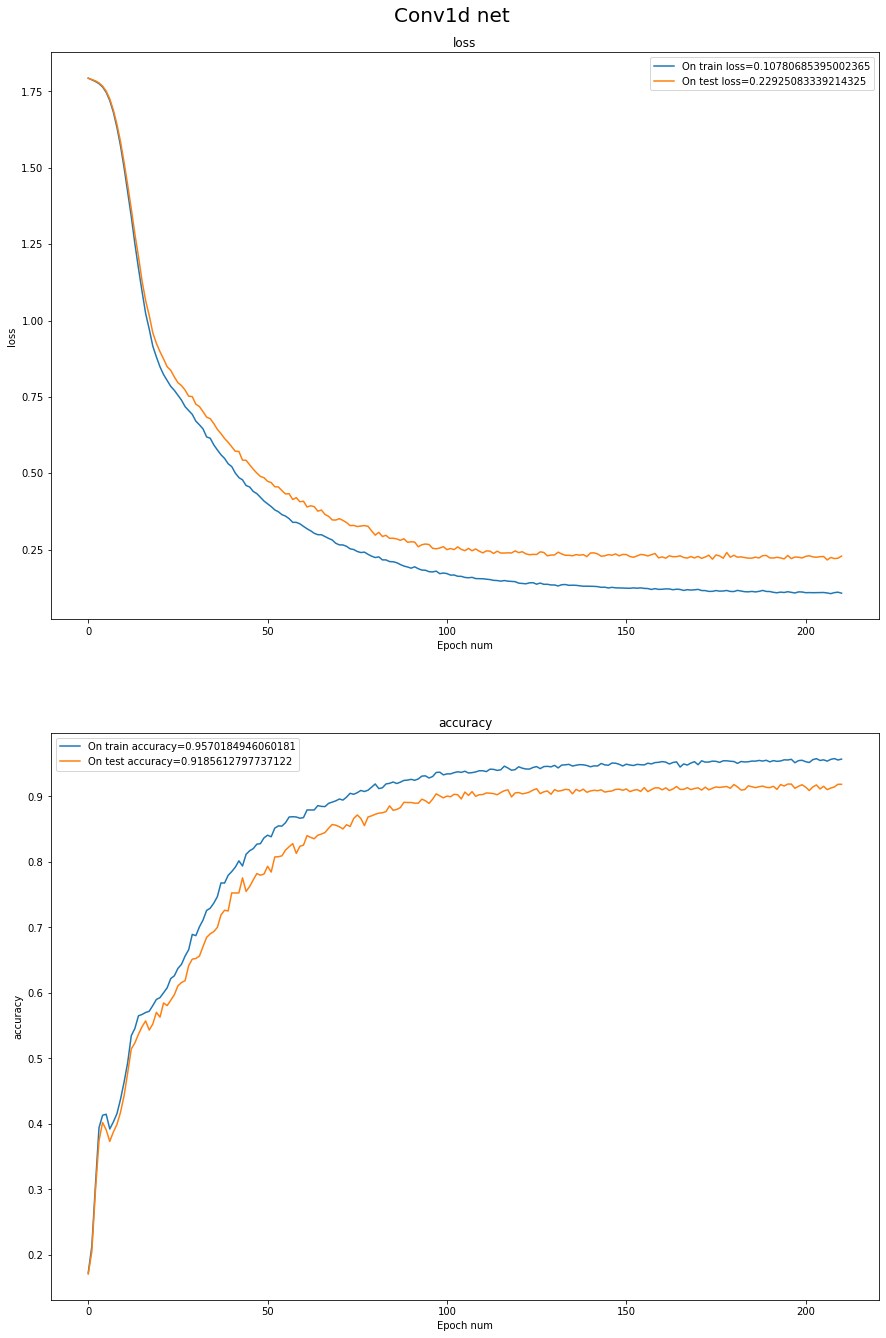

KeyboardInterrupt: ignored

In [169]:
%%time 
convnet_2fc = get_convnet_2fc([9, 128], 6).to(device)
convnet_2fc_lm = LearningModel(convnet_2fc, 'Conv1d net')
convnet_2fc_lm.fit(
    {
        'train' : train_dataloader,
        'test' : test_dataloader
    },
    n_epoch=400
)

## Выводы

После выполнения задания заполните небольшой отчет об экспериментах вида "Я пробовал(а) ... подходы и получил(а) ... результаты. Наконец, после N+1 чашки кофе/бессонной ночи у меня получилось, и весь секрет был в ..."

**Ответ**

После одной чашечки зелёного чая с имберём была понята [статья](https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/) и вскоре реализована)

Получилось довольно быстро, так как большая работа была проделана над придумыванием паттерна решения задач, а именно реализация класса LearningModel, который учит переданную ему сеть.

Но первоначальное решение всё равно не дотягивало до 91% точности, так как переобучалось. Для исправления этой ошибки добавил ещё один полносвязный слой и дропаут - **помогло**)